# Dog Breed Classification Utilizing Convolutional Neural Networks

This notebook utilizes Convolutional Neural Networks to determine whether a human or dog is present in an image. If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays sample output.

![Sample Dog Output](images/sample_dog_output.png)

### Image Classification Steps

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Download the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

If utilizing [FloydHub](https://www.floydhub.com) as backend, set `platform_floyd = True` in the next code cell.

In [2]:
import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# If using Floyd, set datapath for mounted datasets.
data_path_prefix = ""

platform_floyd = True
if platform_floyd:
    data_path_prefix = "/floyd/input/"

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob(data_path_prefix + "lfw/*/*"))
dog_files = np.array(glob(data_path_prefix + "dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13220 total human images.
There are 8343 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is utilized to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  This repository contains one of these detectors and is stored in the `haarcascades` directory.

Number of faces detected: 1


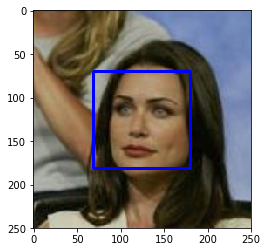

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

The function below returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector

The code cell below assesses the performance on the `face_detector` function above. It checks for the following two questions:

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  The algorithm falls short of this goal, but still gives acceptable performance.  File paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [8]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_face_human_dataset_detect_cnt = 0
human_face_dog_dataset_detect_cnt = 0

for human in human_files_short:
    if face_detector(human):
        human_face_human_dataset_detect_cnt += 1

print("Percentage of human_files_short detected with human face: " + 
      "{:.2%}".format(human_face_human_dataset_detect_cnt / 
                      len(human_files_short)))

for dog in dog_files_short:
    if face_detector(dog):
        human_face_dog_dataset_detect_cnt += 1

print("Percentage of dog_files_short detected with human face: " + 
      "{:.2%}".format(human_face_dog_dataset_detect_cnt / 
                      len(dog_files_short)))

Percentage of human_files_short detected with human face: 100.00%
Percentage of dog_files_short detected with human face: 10.00%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this step, the [VGG-16 pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) is used to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/).

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 61246940.34it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with VGG16

The `VGG16_predict` function in the code cell below accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should is an integer between 0 and 999, inclusive.

In [14]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # import image
    image = Image.open(img_path)
    
    # Set VGG16 model to eval() mode.
    VGG16.eval()
    
    # Note: normalized images based on VGG-16 requirements found at:
    # https://pytorch.org/docs/stable/torchvision/models.html
    # Calls for normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

    transformed_tensor_image = transform(image)
    
    # get rid of first dimension
    # Model expects mini-batch of 3-channel (RGB) images. Therefore, sending a mini-batch of size 1. Using unsqueeze(0)
    # to make it a batch of size 1.
    transformed_tensor_image = transformed_tensor_image.unsqueeze(0)
    
    # move tensor to cuda if using cuda
    if use_cuda:
        transformed_tensor_image = transformed_tensor_image.cuda()
    
    # make prediction using VGG16 model
    prediction_all = VGG16(transformed_tensor_image)
    
    # Move back to cpu to use numpy if using cuda
    if use_cuda:
        prediction_all = prediction_all.cpu()
    
    # Convert prediction back to numpy array to use argmax() function
    best_prediction = prediction_all.data.numpy().argmax()
    
    return best_prediction # predicted class index

In [15]:
VGG16_predict(data_path_prefix + "dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg")

# Output should be: 252

252

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/floyd/input/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg


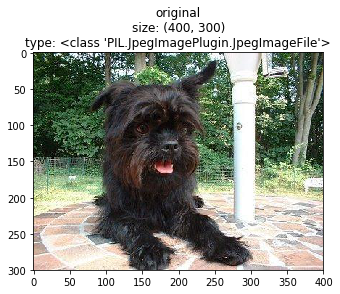

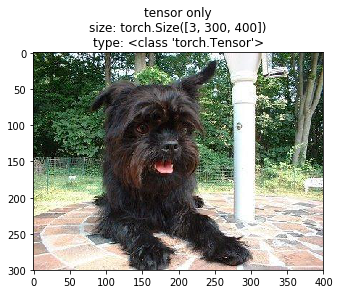

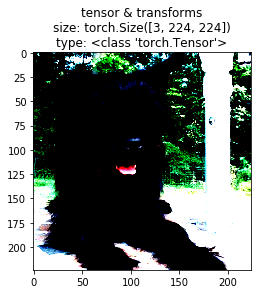

In [54]:
# The following code is used to understand the transformations applied to an image
# For future reference

import matplotlib.pyplot as plt 
%matplotlib inline

plot_images = {}

img_path = data_path_prefix + "dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg"
print(img_path)
image = Image.open(img_path)
#print(type(image))
#print(image.mode)
#print(image.size)
#print(image.format)
#print(image.width)
#print(image.height)
plot_images["original\nsize: " + str(image.size) + "\ntype: " + str(type(image))] = image 
#plt.imshow(image)
convertToTensor = transforms.ToTensor()
tensor_image = convertToTensor(image)
#print(type(tensor_image))
#print(tensor_image.shape)
tensor_image_plot = np.transpose(tensor_image, (1,2,0))
plot_images["tensor only\nsize: " + str(tensor_image.shape) + "\ntype: " + str(type(tensor_image))] = tensor_image_plot
transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#print(type(transform))
transformed_tensor_image = transform(image)
#print(type(transformed_tensor_image))
#print(transformed_tensor_image.shape)
#plt.imshow(new_image)
transformed_tensor_image_plot = np.transpose(transformed_tensor_image, (1,2,0))
plot_images["tensor & transforms\nsize: " + str(transformed_tensor_image.shape) + "\ntype: " + str(type(transformed_tensor_image))] = transformed_tensor_image_plot

# Plot images to show image as it moves through data conversions & transformations.
for title, img in plot_images.items():
    plt.figure()
    plt.title(title)
    plt.imshow(img)

### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

The `dog_detector` function below utilizes this range, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    prediction = VGG16_predict(img_path)
    
    # return True if prediction between 151-268, inclusive
    if 151 <= prediction <= 268:
        return True
    else:
        return False

In [17]:
# Test dog_detector() function. Output should be True.
img_path = data_path_prefix + "dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg"
dog_detector(img_path) # Should return True for the given img_path

True

### Assessing the Dog Detector

The code cell below tests the performance of the `dog_detector` function by answering the following questions:

- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [46]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detected_human_dataset_cnt = 0
dog_detected_dog_dataset_cnt = 0

for human in human_files_short:
    if dog_detector(human):
        dog_detected_human_dataset_cnt += 1

print("Percentage of human_files_short with dog detected: " + 
      "{:.2%}".format(dog_detected_human_dataset_cnt / 
                      len(human_files_short)))

for dog in dog_files_short:
    if dog_detector(dog):
        dog_detected_dog_dataset_cnt += 1

print("Percentage of dog_files_short with dog detected: " + 
      "{:.2%}".format(dog_detected_dog_dataset_cnt / 
                      len(dog_files_short)))

Percentage of human_files_short with dog detected: 0.00%
Percentage of dog_files_short with dog detected: 97.00%


---
<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, the CNN classifies dog breeds. CNN is created _from scratch_ (so, no transfer learning _yet_).

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  The vision-based algorithm below conquers this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%. 

In [11]:
# Image file analysis to use for best resizing, cropping operations
import os
import pandas as pd
from pathlib import Path
dir = data_path_prefix + "dogImages"
files_list = []

df_idx = 0

# Create pandas dataframe for image width & height analysis
df = pd.DataFrame(columns=['full_path','relative_path','width','height'])

# Find all images underneath dogImages directory and store width & height.
for subdir, dirs, files in os.walk(dir):
    for file in files:
        image = Image.open(os.path.join(subdir, file))
        path = Path(os.path.join(subdir, file))
        file_id = path.parent.parent.name + "/" + file
        
        rel_path = path.parent.parent.name + "/" + file
        full_path = os.path.join(subdir, file)
        width = image.width
        height = image.height
        df.loc[df_idx] = [full_path] + [rel_path] +  [width] + [height]
        df_idx += 1
        
df["width"] = pd.to_numeric(df["width"])
df["height"] = pd.to_numeric(df["height"])   

largest_width = df.iloc[df["width"].idxmax()]
largest_height = df.iloc[df["height"].idxmax()]
smallest_width = df.iloc[df["width"].idxmin()]
smallest_height = df.iloc[df["height"].idxmin()]
average_width = df.iloc[df["width"].idxmin()]
average_height = df.iloc[df["height"].idxmin()]

print("Largest width: " + largest_width["relative_path"] + " with width of " + str(largest_width["width"]))
print("Largest height: " + largest_height["relative_path"] + " with height of " + str(largest_height["height"]))
print("Smallest width: " + smallest_width["relative_path"] + " with width of " + str(smallest_width["width"]))
print("Smallest height: " + smallest_height["relative_path"] + " with height of " + str(smallest_height["height"]))

print("Mean pixels:")
print(df.mean(axis = 0, skipna = True))
print("\nMedian pixels:")
print(df.median(axis = 0, skipna = True))
print("\nMode of width & height pixels:")
print(df.mode(axis = 0, numeric_only = True))

Largest width: train/Great_pyrenees_05429.jpg with width of 4278
Largest height: train/Gordon_setter_05313.jpg with height of 4003
Smallest width: valid/Bedlington_terrier_01367.jpg with width of 105
Smallest height: train/Alaskan_malamute_00320.jpg with height of 113
Mean pixels:
width     567.164090
height    529.105478
dtype: float64

Median pixels:
width     500.0
height    468.0
dtype: float64

Mode of width & height pixels:
   width  height
0    500     640


#### Determination of model transformed image pixel size based on analysis

Reviewing the above pixel image data, the median pixel width is 500 and height 468. $8 \times 2^6$ is 512 pixels so a best practice pixel based on a power of 2. The first model I tried used a transforms.Resize(530) and a transforms.CenterCrop(512). It really increased the input dimensionality and required using a larger maxpooling layer. Unfortunately it did require more GPU memory and training time. In addition, couldn't find model architecture that would converge quickly enough based on GPU / cost contraints. Ultimately decided upon a Resize(255) and CenterCrop(224) based on GPU / training time contraints. 

 
### Data Loaders for the Dog Dataset

The code cell below has three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  The following documentation [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  

In [4]:
# Created load_data_scratch() function as to parameterize the num_workers and batch_size. This provided the ability to 
# to test for best value of each based on the platform being executed on. A num_workers of 0 actually took MUCH longer
# than specifying 4 or 8 or even 16. The training of the models were actually bound by the CPU and NOT the GPU on the
# platforms I used to train on. The CPU is heavily used for the following transforms.Compose as they are executed on CPU
# and not GPU. More below on this issue.

# transforms.Normalize() below is centered between 0 and 1 on all 3 channels (RGB) to ensure no input dimension is given
# more weight and that the model converges without vanishing gradients.

# Shuffled data to ensure that the model learned from different combinations of images for each batch.

def load_data_scratch(num_workers, batch_size):
    train_transforms = transforms.Compose([
                                       transforms.Resize(255), # Resize to smallest mean dimension (width)
                                       transforms.CenterCrop(224), # crop near median original image size
                                       transforms.RandomRotation(60), # to minimize angular variance
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ]) 

    test_transforms = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

    valid_transforms = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(244),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

    train_data = datasets.ImageFolder(data_path_prefix + "dogImages/train", transform=train_transforms)
    test_data = datasets.ImageFolder(data_path_prefix + "dogImages/test", transform=test_transforms)
    valid_data = datasets.ImageFolder(data_path_prefix + "dogImages/valid", transform=test_transforms)

    loaders_scratch = {}
    loaders_scratch["train"] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    loaders_scratch["test"] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    loaders_scratch["valid"] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    return loaders_scratch

In [6]:
# Determine number of unique output classes between train, valid,
# and test data sets.

print(type(train_data))

# Determine number of classes for all 3 sets: train, test, valid. 
print(len(set(test_data.classes)))
print(len(set(train_data.classes)))
print(len(set(valid_data.classes)))

# Ensure all test_data classes included in train_data. Should return empty set().
print(set(train_data.classes)-set(test_data.classes))

# Ensure all valid_data classes included in train_data. Should return empty set().
print(set(train_data.classes)-set(valid_data.classes))

# So 133 unique dog classes. So, there should be 133 outputs in the
# output layer. All 133 dog classes present in train, test, & valid
# datasets.

<class 'torchvision.datasets.folder.ImageFolder'>
133
133
133
set()
set()


#### Determination of model transformed image pixel size based on analysis

Reviewing the above pixel image data, the median pixel width is 500 and height 468. $8 \times 2^6$ is 512 pixels so a best practice pixel based on a power of 2. The first model I tried used a transforms.Resize(530) and a transforms.CenterCrop(512). It really increased the input dimensionality and required using a larger maxpooling layer. Unfortunately it did require more GPU memory and training time. In addition, couldn't find model architecture that would converge quickly enough based on GPU / cost contraints. Ultimately decided upon a Resize(255) and CenterCrop(224) based on GPU / training time contraints. 

#### Image augmentation

With only the training dataset, the following transforms were used:
- RandomRotation(60)
  - To capture dogs that may be in different angles within an image. i.e. Catching a frisbee.
- RandomHorizontalFlip
  - Capture dogs that may be lying on their back. i.e. For a stomach pet.

### Model Architecture

The code cell below creates a CNN to classify dog breed.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolution layer (sees 28x28x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolution layer (sees 14x14x128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (256 * 7 * 7 -> 6000)
        self.fc1 = nn.Linear(256 * 7 * 7, 6000)
        # linear layer (6000 -> 3000)
        self.fc2 = nn.Linear(6000, 3000)
        # linear layer (3000 -> 133)
        # 133 dog classes to predict
        self.fc3 = nn.Linear(3000, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        # out 112x112x16
        x = self.pool(F.relu(self.conv2(x)))
        # out 56x56x32
        x = self.pool(F.relu(self.conv3(x)))
        # out 28x28x64
        x = self.pool(F.relu(self.conv4(x)))
        # out 14x14x128
        x = self.pool(F.relu(self.conv5(x)))
        # out 7x7x256
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### 512x512 images. 7 convolutional layers. 2x2 max pooling layers only.

#### Result:

Could not get to converge in a timely manner. Attempted with both SGD(lr=.01) and Adam(lr=.001). Therefore, scrapped this model.

```python
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 512x512x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 256x256x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 128x128x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolution layer (sees 64x64x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolution layer (sees 32x32x128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # convolution layer (sees 16x16x256 tensor)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        # convolution layer (sees 8x8x512 tensor)
        self.conv7 = nn.Conv2d(512, 1024, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (1024 * 4 * 4 -> 6000)
        self.fc1 = nn.Linear(1024 * 4 * 4, 6000)
        # linear layer (6000 -> 3000)
        self.fc2 = nn.Linear(6000, 3000)
        # linear layer (3000 -> 133)
        # 133 dog classes to predict
        self.fc3 = nn.Linear(3000, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        # out 256x256x16
        x = self.pool(F.relu(self.conv2(x)))
        # out 128x128x32
        x = self.pool(F.relu(self.conv3(x)))
        # out 64x64x64
        x = self.pool(F.relu(self.conv4(x)))
        # out 32x32x128
        x = self.pool(F.relu(self.conv5(x)))
        # out 16x16x256
        x = self.pool(F.relu(self.conv6(x)))
        # out 8x8x512
        x = self.pool(F.relu(self.conv7(x)))
        # out 4x4x1024
        # flatten image input
        x = x.view(-1, 1024 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
```

### 512x512 images. 4 convolutional layers. 2x2 and 4x4 max pooling layers. Early 4x4 max pooling followed by 2x2.

#### Result:

Used a max pooling layer of 4x4 on the first couple of layers to greatly reduce dimensionality before entering the linear classifer layer. Could not get to converge in a timely manner. Attempted with both SGD(lr=.01) and Adam(lr=.001). Therefore, scrapped this model too. 

```python
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 512x512x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 128x128x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 32x32x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolution layer (sees 16x16x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer 2x2
        self.pool2 = nn.MaxPool2d(2, 2)
        # max pooling layer 4x4
        self.pool4 = nn.MaxPool2d(4, 4)
        # linear layer (128 * 8 * 8 -> 4096)
        self.fc1 = nn.Linear(128 * 8 * 8, 4096)
        # linear layer (4096 -> 2048)
        self.fc2 = nn.Linear(4096, 2048)
        # linear layer (2048 -> 133)
        # 133 dog classes to predict
        self.fc3 = nn.Linear(2048, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool4(F.relu(self.conv1(x)))
        # out 128x128x16
        x = self.pool4(F.relu(self.conv2(x)))
        # out 32x32x32
        x = self.pool2(F.relu(self.conv3(x)))
        # out 16x16x64
        x = self.pool2(F.relu(self.conv4(x)))
        # out 8x8x128
        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
```

### 512x512 images. 4 convolutional layers. 2x2 and 4x4 max pooling layers. Early 2x2 max pooling followed by 4x4.

#### Result:

Used a max pooling layer of 2x2 on the first couple of layers slowing decreased dimensionality. Thinking for using smaller max pooling after first couple of convolutions is it would pick up finer grained details such as lines.  Could not get to converge in a timely manner. Attempted with both SGD(lr=.01) and Adam(lr=.001). Therefore, scrapped this model too. 

```python
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 512x512x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 256x256x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 128x128x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolution layer (sees 32x32x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer 2x2
        self.pool2 = nn.MaxPool2d(2, 2)
        # max pooling layer 4x4
        self.pool4 = nn.MaxPool2d(4, 4)
        # linear layer (128 * 8 * 8 -> 4096)
        self.fc1 = nn.Linear(128 * 8 * 8, 4096)
        # linear layer (4096 -> 2048)
        self.fc2 = nn.Linear(4096, 2048)
        # linear layer (2048 -> 133)
        # 133 dog classes to predict
        self.fc3 = nn.Linear(2048, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool2(F.relu(self.conv1(x)))
        # out 256x256x16
        x = self.pool2(F.relu(self.conv2(x)))
        # out 128x128x32
        x = self.pool4(F.relu(self.conv3(x)))
        # out 32x32x64
        x = self.pool4(F.relu(self.conv4(x)))
        # out 8x8x128
        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
```

### Steps I took to get to my final CNN architecture:  

| Model Attempt | Model Description | Image Size |
| ------------- | ---------- | ------- |
| 1 | 4 Convolutions, 4x4 max pooling early | 512 |  
| 2 | 4 Convolutions, 2x2 max pooling early | 512 | 
| 3 | 7 Convolutions, 2x2 max pooling only  | 512 |
| 4 | 5 Convolutions, 2x2 max pooling only  | 224 |

#### Model #1:

Used a max pooling layer of 4x4 on the first couple of layers to greatly reduce dimensionality before entering the linear classifer layer. Could not get to converge in a timely manner. Attempted with both SGD(lr=.01) and Adam(lr=.001). Therefore, scrapped this model.

#### Model #2:

Used a max pooling layer of 2x2 on the first couple of layers slowing decreased dimensionality. Thinking for using smaller max pooling after first couple of convolutions is it would pick up finer grained details such as lines. Could not get to converge in a timely manner. Attempted with both SGD(lr=.01) and Adam(lr=.001). Therefore, scrapped this model.

#### Model #3:

Could not get to converge in a timely manner. Attempted with both SGD(lr=.01) and Adam(lr=.001). Therefore, scrapped this model.

#### Model #4 (final):

Used 224 square pixel images. Reduced input dimensionality increased training performance and allowed model to finish in reasonable amout of time with greater than 10% accuracy. Attempted both Adam and SGD as optimizers. Ultimately decided on SGD with larger learning rate (0.1) to converge the model more quickly. Attempted learning rates of 0.01 and 0.03 and the model was not converging quickly enough.

### Specify Loss Function and Optimizer

The next code cell specifies a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  The loss function is stored in the variable `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [6]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()
#criterion_scratch = nn.NLLLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.1)

### Train and Validate the Model

The code cell below trains and validates the model.  [Final model parameters](http://pytorch.org/docs/master/notes/serialization.html) are saved to filepath `'model_scratch.pt'`.

In [9]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    total_seconds = 0.0
    
    for epoch in range(1, n_epochs+1):
        # time each epoch
        begin_time = time.time()
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders["train"].sampler)
        valid_loss = valid_loss/len(loaders["valid"].sampler)
        
        end_time = time.time()
        epoch_total_seconds = end_time - begin_time
        total_seconds += epoch_total_seconds
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tEpoch Run Time: {:.1f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            epoch_total_seconds
            ))
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
            # see if test_accuracy > 10%; if so exit
            # call test function    
            test_accuracy = test(loaders, model, criterion, use_cuda)
            print("Test accuracy after best epoch: {:.6f}".format(test_accuracy))
            if test_accuracy > 10.:
                break # don't run another epoch since target threshold met

    model_avg_seconds = total_seconds / n_epochs
    
    
    # return trained model
    return model, model_avg_seconds

### Determine quickest num_workers & batch_size on currently running platform


#### Findings:

Using num_workers = 0 really increased overall runtime and hence cost. The GPU is underutilized. The bottleneck is with the CPU during the image transforms.Compose pipeline. Researched whether this could be done on the GPU in PyTorch and found open GitHub issue debating whether to include the image transform pipeline on the GPU. It appears it would be a performance hit in most cases to do so as the GPU wouldn't be as efficient. But the CPU on Floyd is unable to keep the GPU fed with processing in this specific model. The model ran quicker on the Floyd gpu2 due primarily to the 8 vCPU and NOT the better GPU.

```python
# train the model
fastest_time = np.Inf
run_time = np.Inf
fastest_batch_size = ""
fastest_num_workers = ""
batch_size = [20, 32, 64, 128, 160, 200, 256]
num_workers = [0, 4, 8, 16, 32]

# Loop through all permutations to determine quickest setup. Run only 2 epochs and take average.
for batch in batch_size:
    for workers in num_workers:
        print("Starting... batch_size: " + str(batch) + " num_workers: " + str(workers))
        loaders_scratch = load_data_scratch(workers, batch)
        model_scratch, model_avg_seconds = train(2, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')
        # Cleanup GPU memory
        torch.cuda.empty_cache()
        if model_avg_seconds < fastest_time:
            fastest_time = model_avg_seconds
            fastest_batch_size = batch
            fastest_num_workers = workers
            print("Fastest so far... avg time: {:.1f}".format(fastest_time) + " batch_size: " + str(batch) + " num_workers: " + str(workers))

print("Fastest: batch_size=" + str(fastest_batch_size) + " num_workers=" + str(fastest_num_workers) + " time was {:.1f}".format(fastest_time))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
```
#### Best times on Floyd gpu2

Running on Floyd Tesla V100 (16GB memory) with 8 vCPU.

Starting... batch_size: 64 num_workers: 8  
Epoch: 1 	Training Loss: 4.864016 	Validation Loss: 4.868777 	Epoch Run Time: 33.5  
Validation loss decreased (inf --> 4.868777).  Saving model ...  
Epoch: 2 	Training Loss: 4.864010 	Validation Loss: 4.868934 	Epoch Run Time: 34.4  
Fastest so far... avg time: 34.0 batch_size: 64 num_workers: 8  
Fastest: batch_size=64 num_workers=8 time was 34.0

Total cost (50 epochs):  \\$1.98  
>\\$0.07 per minute x (50 * 34 / 60) 

Total train time (50 epochs): ~29 minutes    

Outcome: Twice as quick but 1.75x the cost of lesser gpu machine. 

#### Best times on Floyd gpu  

Running on Floyd Tesla K80 (12GB memory) with 4 vCPU.

Starting... batch_size: 160 num_workers: 8  
Epoch: 1 	Training Loss: 4.862784 	Validation Loss: 4.869006 	Epoch Run Time: 67.7  
Validation loss decreased (inf --> 4.869006).  Saving model ...  
Epoch: 2 	Training Loss: 4.862878 	Validation Loss: 4.869014 	Epoch Run Time: 68.2  
Fastest so far... avg time: 68.0 batch_size: 160 num_workers: 8  
Fastest: batch_size=160 num_workers=8 time was 68.0

Total cost (50 epochs): \\$1.13 
>\\$0.02 per minute x (50 * 68 / 60)  

Total train time (50 epochs): ~57 minutes

In [10]:
# Called test() function after each best validation loss decrease to see if target >10% accuracy achieved. 
# num_workers: 8, batch_size: 64
# SGD, 0.1, test #2
loaders_scratch = load_data_scratch(8, 64)

model_scratch, model_avg_seconds = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                                         criterion_scratch, use_cuda, 'model_scratch.pt')


# Cleanup GPU memory
torch.cuda.empty_cache()

Epoch: 1 	Training Loss: 4.889047 	Validation Loss: 4.885602 	Epoch Run Time: 37.6
Validation loss decreased (inf --> 4.885602).  Saving model ...
Test Loss: 4.883729


Test Accuracy:  1% (10/836)
Test accuracy after best epoch: 1.196172
Epoch: 2 	Training Loss: 4.883453 	Validation Loss: 4.880272 	Epoch Run Time: 37.9
Validation loss decreased (4.885602 --> 4.880272).  Saving model ...
Test Loss: 4.878103


Test Accuracy:  1% ( 9/836)
Test accuracy after best epoch: 1.076555
Epoch: 3 	Training Loss: 4.875838 	Validation Loss: 4.870246 	Epoch Run Time: 38.2
Validation loss decreased (4.880272 --> 4.870246).  Saving model ...
Test Loss: 4.865624


Test Accuracy:  1% (10/836)
Test accuracy after best epoch: 1.196172
Epoch: 4 	Training Loss: 4.871457 	Validation Loss: 4.868384 	Epoch Run Time: 39.9
Validation loss decreased (4.870246 --> 4.868384).  Saving model ...
Test Loss: 4.868873


Test Accuracy:  1% (10/836)
Test accuracy after best epoch: 1.196172
Epoch: 5 	Training Loss: 4.868255

### Testing the Model

Testing the model on the test dataset of dog images. The code cell below calculates and prints the test loss and accuracy.

In [7]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return 100. * correct / total

In [11]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.858254


Test Accuracy: 10% (87/836)


10.4066985645933

---
<a id='step4'></a>
## Step 4: CNN to Classify Dog Breeds (using Transfer Learning)

Utilize transfer learning to create a CNN that can identify dog breed from images. The CNN attains at least 60% accuracy on the test set.

### Data Loaders for the Dog Dataset

The code cell below contains three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

In [120]:
# Create class dictionary for dog classes 
# Will use later during prediction phase

import os
classes_transfer = {}
# All train, test, valid folders have same sub-directories & therefore classes.
# Therefore, just chose one of the top level directories to traverse.
dir = data_path_prefix + "dogImages/train"

# Return immediate subdirectories
dir_list = next(os.walk(dir))[1]
for dir_name in dir_list:
    # Parse subdirectory name
    # First 3 characters of string indicate class number
    # Characters 4 to end of string represent dog breed name. Replaced underscores for legibility.
    classes_transfer[int(dir_name[:3])] = dir_name[4:].replace("_", " ")

#print(classes_transfer[1])

In [19]:
# Specify data loaders

num_workers = 0
# increase batch size if using cuda on Floyd
if use_cuda:
    batch_size = 220
else:
    batch_size = 64

# Note: normalized images based on VGG-16 requirements found at:
# https://pytorch.org/docs/stable/torchvision/models.html
# Calls for normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

normalize_transfer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(60),
                                       #transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize_transfer
                                       ]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize_transfer
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize_transfer
                                      ])

train_data = datasets.ImageFolder(data_path_prefix + "dogImages/train", transform=train_transforms)
test_data = datasets.ImageFolder(data_path_prefix + "dogImages/test", transform=test_transforms)
valid_data = datasets.ImageFolder(data_path_prefix + "dogImages/valid", transform=test_transforms)

loaders_transfer = {}
loaders_transfer["train"] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_transfer["test"] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_transfer["valid"] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

### Model Architecture

Transfer learning is utilized below to create a CNN to classify dog breed. The initialized model is saved to the variable `model_transfer`.

In [123]:
import torchvision.models as models
import torch.nn as nn

# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# Do not train the features' parameters.
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Determine index of last classifer layer
last_classifer_layer = len(list(model_transfer.classifier)) - 1

# Set inputs / outputs. Chose to use train_data.classes instead of classes_transfer dictionary created above.
# Both have same result
n_inputs = model_transfer.classifier[last_classifer_layer].in_features
n_outputs = len(train_data.classes)
last_layer = nn.Linear(n_inputs, n_outputs)

# Current last layer has 1000 outputs. Will update to only output 133 outputs based on spec.
print(model_transfer.classifier[last_classifer_layer])

# Can see that last layer is 4096x133.
print(last_layer)

# Change last classifier layer with new last layer.
model_transfer.classifier[last_classifer_layer] = last_layer

# Move model to GPU if available.
if use_cuda:
    model_transfer = model_transfer.cuda()
    
# print out the model structure
print(model_transfer)

Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=133, bias=True)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(i

__Steps taken to determine final CNN architecture:__ 

- Determined number of classes required for output layer
  - Traversed file system to determine number of classes and placed into classes_transfer for later use
- Chose existing model VGG-16 since it's feature detector is well established
- Based on that model, set up data loaders based on required size & normalization found at https://pytorch.org/docs/stable/torchvision/models.html
  - Set batch size based on architecture executing on. Local workstation not has powerful as cloud-based compute at Floyd.

### Loss Function and Optimizer

The next code cell specifies a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  The loss function is saved to `criterion_transfer`, and the optimizer to `optimizer_transfer` below.

In [24]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model

The code cell below trains and validates the model.  [The final model parameters](http://pytorch.org/docs/master/notes/serialization.html) are saved to filepath `'model_transfer.pt'`.

In [13]:
# train the model
n_epochs = 2
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.442811 	Validation Loss: 1.319416
Validation loss decreased (inf --> 1.319416).  Saving model ...
Epoch: 2 	Training Loss: 2.424614 	Validation Loss: 1.025018
Validation loss decreased (1.319416 --> 1.025018).  Saving model ...


In [22]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Testing the Model

The below code cell tests the model on the test dataset of dog images.

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.120507


Test Accuracy: 65% (547/836)


65.43062200956938

### Predict Dog Breed with the Model

The function below takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [116]:
def predict_breed_transfer(img_path):
    
    # set model_transfer.eval() on
    model_transfer.eval()
    # load the image and return the predicted breed
    image = Image.open(img_path)    
    transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize_transfer
                                      ])

    transformed_tensor_image = transform(image)
    transformed_tensor_image = transformed_tensor_image.unsqueeze(0)
    if use_cuda:
        transformed_tensor_image = transformed_tensor_image.cuda()
    prediction_all = model_transfer(transformed_tensor_image)
    # move tensor to cuda if using cuda
    if use_cuda:
        prediction_all = prediction_all.cpu()
    
    best_prediction = prediction_all.data.numpy().argmax()
    #print(classes_transfer[best_prediction])
    return str(best_prediction) + ": " + classes_transfer[best_prediction] # predicted class index

    

In [24]:
# Convert to html
!jupyter nbconvert --to html dog_app.ipynb

[NbConvertApp] Converting notebook dog_app.ipynb to html
[NbConvertApp] Writing 1837001 bytes to dog_app.html


In [25]:
# Save directory minus checkpoint files since will be over size limit (500MB) 
!tar -czvf ../dog-project.tar.gz --exclude='*.pt' --exclude='*.sh' ../home

tar: Removing leading `../' from member names
../home/
../home/startFloydGPU_power.sh.gz
../home/dog_app.html
../home/floyd.yml
../home/images/
../home/images/Labrador_retriever_06449.jpg
../home/images/Labrador_retriever_06457.jpg
../home/images/Brittany_02625.jpg
../home/images/sample_dog_output.png
../home/images/American_water_spaniel_00648.jpg
../home/images/Labrador_retriever_06455.jpg
../home/images/sample_human_output.png
../home/images/Curly-coated_retriever_03896.jpg
../home/images/.ipynb_checkpoints/
../home/images/sample_cnn.png
../home/images/step6_test_images/
../home/images/step6_test_images/dog_chinook.jpg
../home/images/step6_test_images/schnauzer.jpg
../home/images/step6_test_images/obama.jpg
../home/images/step6_test_images/tree.jpg
../home/images/step6_test_images/jenny_lake.png
../home/images/step6_test_images/.ipynb_checkpoints/
../home/images/Welsh_springer_spaniel_08203.jpg
../home/.floydignore.gz
../home/.floydexpt
../home/dog_app.ipynb
../home/.ipynb_checkpoin